<a href="https://colab.research.google.com/github/ApoorvaNagarajan/Image-Filter-Kernels/blob/master/assignment6/assignment6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import all the required python libraries

from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D, DepthwiseConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input, concatenate
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.models import Model

In [0]:
from keras.datasets import cifar10

# downloads the CIFAR10 dataset and splits it into test and train.
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

# calculate the dimensions and number of classes
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

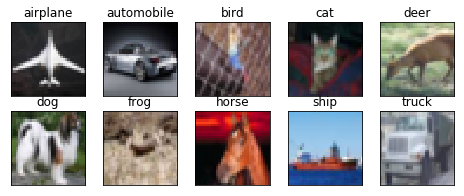

In [35]:
# gallery to display 1 image from each of the classes

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# function to plot loss and accuracy of the network

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# function to calculate accuacy

def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
#pixel normalization of test and train data
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255


# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
# Define the model
# Using functional API as we need to use group convolution

input_img = Input(shape=(32, 32, 3))

layer1 = Conv2D(32, (3, 3), padding='same')(input_img) # RF: 3x3
layer1_bn = BatchNormalization()(layer1)
layer1_act = Activation('relu')(layer1_bn)

layer2 = Conv2D(64, (3, 1), padding='same')(layer1_act) # RF: 5x3
layer2_bn = BatchNormalization()(layer2)
layer2_act = Activation('relu')(layer2_bn)
layer3 = Conv2D(64, (1, 3), padding='same')(layer2_act) # RF: 5x5
layer3_bn = BatchNormalization()(layer3)
layer3_act = Activation('relu')(layer3_bn)


layer4 = DepthwiseConv2D(64, (3,3), padding='same')(layer3_act) # RF: 7x7
layer5 = Conv2D(128, (1, 1), padding='same')(layer4) # RF: 7x7
layer5_bn = BatchNormalization()(layer5)
layer5_act = Activation('relu')(layer5_bn)


layer6a = Conv2D(128, (3, 3), padding='same')(layer5_act) # RF: 9x9
layer6a_bn = BatchNormalization()(layer6a)
layer6a_act = Activation('relu')(layer6a_bn)

layer6b = Conv2D(128, (5, 5), padding='same')(layer5_act) # RF: 11x11
layer6b_bn = BatchNormalization()(layer6b)
layer6b_act = Activation('relu')(layer6b_bn)

l6_merged = concatenate([layer6a_act, layer6b_act], axis=-1) #RF : 9x9 , 11x11

layer7a = Conv2D(128, (3, 3), padding='same')(l6_merged), # RF : 11x11, 13x13
layer7a_bn = BatchNormalization()(layer7a)
layer7a_act = Activation('relu')(layer7a_bn)
layer7a1 = MaxPooling2D((2,2), padding='same')(layer7a_act) #RF : 22x22, 26x26

layer7b = Conv2D(128, (3, 3), padding='same', strides=2)(l6_merged)  #RF : 22x22, 26x26
layer7b_bn = BatchNormalization()(layer7b)
layer7b_act = Activation('relu')(layer7b_bn)

l7_merged = concatenate([layer7a1, layer7b_act], axis=-1) #RF : 22x22, 26x26

layer8 = Conv2D(num_classes, (6,6))(l7_merged)

layer9 = Flatten()(layer8)
out = Activation('softmax')(layer9)

model = Model(inputs=[input_img], outputs=[out])


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [40]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_99 (Conv2D)              (None, 32, 32, 32)   896         input_16[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         conv2d_99[0][0]                  
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 32, 32, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50
390/390 [==============================] - 116s 298ms/step - loss: 1.9469 - acc: 0.3812 - val_loss: 1.4696 - val_acc: 0.4799
Epoch 2/50
390/390 [==============================] - 112s 287ms/step - loss: 1.3487 - acc: 0.5730 - val_loss: 1.7982 - val_acc: 0.4223
Epoch 3/50
390/390 [==============================] - 96s 246ms/step - loss: 1.0881 - acc: 0.6538 - val_loss: 1.0733 - val_acc: 0.6503
Epoch 4/50
390/390 [==============================] - 108s 277ms/step - loss: 0.8831 - acc: 0.7050 - val_loss: 0.8469 - val_acc: 0.7013
Epoch 5/50
390/390 [==============================] - 112s 287ms/step - loss: 0.7083 - acc: 0.7521 - val_loss: 0.8048 - val_acc: 0.7185
Epoch 6/50
390/390 [==============================] - 113s 289ms/step - loss: 0.6238 - acc: 0.7804 - val_loss: 1.1041 - val_acc: 0.6423
Epoch 7/50
390/390 [==============================] - 112s 288ms/step - loss: 0.5472 - acc: 0.8066 - val_loss: 0.8961 - val_acc: 0.7106
Epoch 8/50
390/390 [=============================

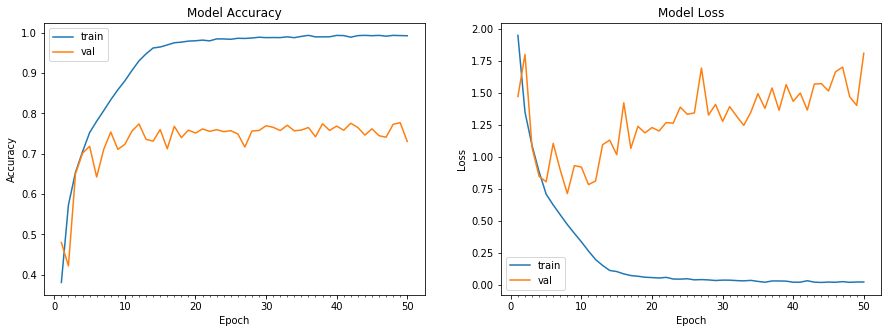

Accuracy on test data is: 73.04


In [41]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))